In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [70]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape)
print(train_labels.shape)
print(train_labels)

print(test_images.shape)
print(test_labels.shape)
print(test_labels)

(60000, 28, 28)
(60000,)
[9 0 0 ... 3 0 5]
(10000, 28, 28)
(10000,)
[9 2 1 ... 8 1 5]


In [71]:
tensor_x = torch.tensor(train_images, dtype=torch.float)
tensor_y = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)

tensor_x = torch.tensor(test_images, dtype=torch.float)
tensor_y = torch.tensor(test_labels, dtype=torch.long)
test_dataset = TensorDataset(tensor_x,tensor_y)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)

    def hidden_layer(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [82]:
def train_network(net, lambda_reg, nepochs):
  for it in range(nepochs):
    for x, t in train_dataloader:
      # Reset gradients to 0:
      optimizer.zero_grad()

      # Forward pass:
      outputs = net(x)
      loss = criterion(outputs, t)

      # L1 regularization:
      l1_term = torch.norm(net.fc1.weight, p=1) + torch.norm(net.fc2.weight, p=1)
      loss += lambda_reg * l1_term

      # Backward pass:
      loss.backward()

      # Actualización de los pesos:
      optimizer.step()

    # Imprimir loss de la época:
    input = torch.tensor(train_images, dtype=torch.float)
    out = net(input)
    _, predicted = torch.max(out, 1)
    acc = (predicted.numpy() == train_labels).sum() / 60000
    print('[%d] loss: %.3f, training acc: %.3f' % (it + 1, loss.item(), acc))

In [83]:
def get_num_internal_states(net, num_bins=10):
  input = torch.tensor(train_images, dtype=torch.float)
  activations = net.hidden_layer(input)
  activations = activations.detach().numpy()

  # Histograma de cada columna:
  b = np.zeros_like(activations)
  for i in range(activations.shape[1]):
    histogram, bin_edges = np.histogram(activations[:, i], bins=num_bins)
    bin_edges[-1] = bin_edges[-1] + 0.01*(bin_edges[-1] - bin_edges[-2])
    b[:, i] = np.digitize(activations[:, i], bin_edges)

  num_states = np.unique(b, axis=0).shape[0]
  print(f"Number of internal states: {num_states}")
  return num_states

In [84]:
reg_values = np.logspace(-4, 0, 20)
num_states = []

for lreg in reg_values:
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters())
  print("-"*60)
  print(f" lreg = {lreg}")
  print("-"*60)
  train_network(net, lreg, 2)
  num_states.append(get_num_internal_states(net, num_bins=5))


------------------------------------------------------------
 lreg = 0.0001
------------------------------------------------------------
[1] loss: 0.523, training acc: 0.840
[2] loss: 0.489, training acc: 0.856
Number of internal states: 53401
------------------------------------------------------------
 lreg = 0.0001623776739188721
------------------------------------------------------------
[1] loss: 0.539, training acc: 0.832
[2] loss: 0.381, training acc: 0.856
Number of internal states: 53781
------------------------------------------------------------
 lreg = 0.00026366508987303583
------------------------------------------------------------
[1] loss: 0.503, training acc: 0.847
[2] loss: 0.464, training acc: 0.865
Number of internal states: 53963
------------------------------------------------------------
 lreg = 0.00042813323987193956
------------------------------------------------------------
[1] loss: 0.730, training acc: 0.840
[2] loss: 0.538, training acc: 0.840
Number of 

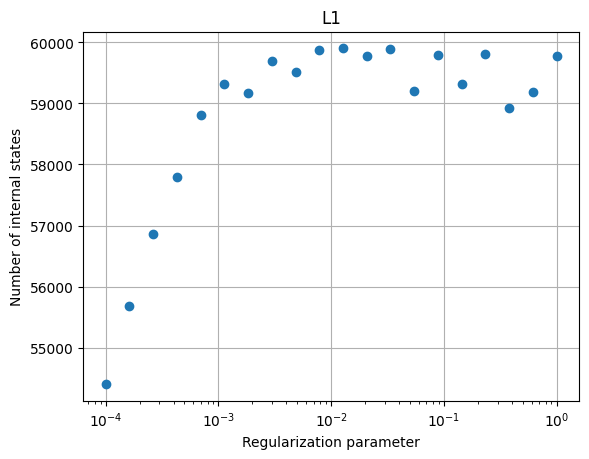

In [81]:
plt.figure()
plt.plot(reg_values, num_states, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Number of internal states')
plt.xscale('log')
plt.title('L1')
plt.grid(True)
plt.show()

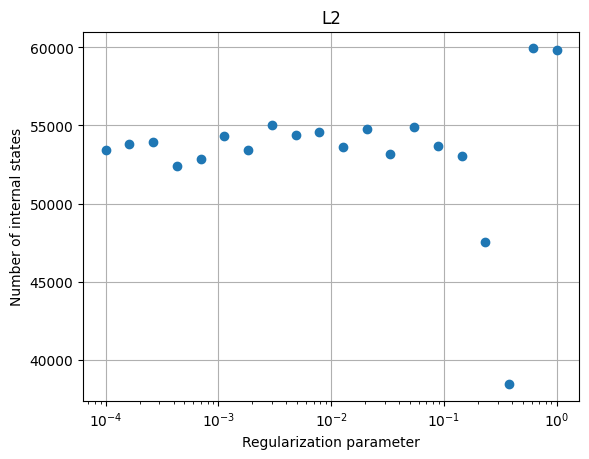

In [85]:
plt.figure()
plt.plot(reg_values, num_states, 'o')
plt.xlabel('Regularization parameter')
plt.ylabel('Number of internal states')
plt.xscale('log')
plt.title('L2')
plt.grid(True)
plt.show()